<a href="https://colab.research.google.com/github/harsh-bat/tensorFlow2Learn/blob/master/WrongWay_Stock_Return_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [5]:
#Starting with the wrong thing to do. Using the close price and predicting future close prices
series = df['close'].values.reshape(-1, 1)

In [6]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [7]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [8]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 29ms/step - loss: 0.0996 - val_loss: 0.2792
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0488
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0457
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0444
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0381
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0304
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0285
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0304
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0787
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.1192
Epoch 11/80
20/20 

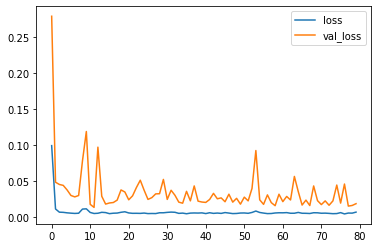

In [9]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


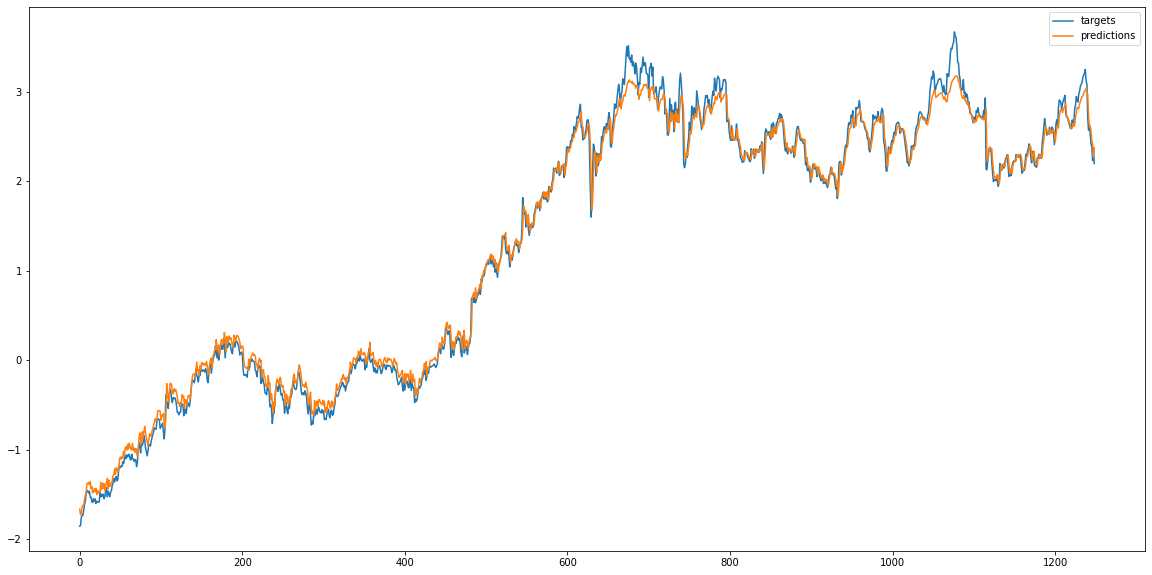

In [12]:
# One step forecast. Super wrong way to do 
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]
plt.figure(figsize=(20,10))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

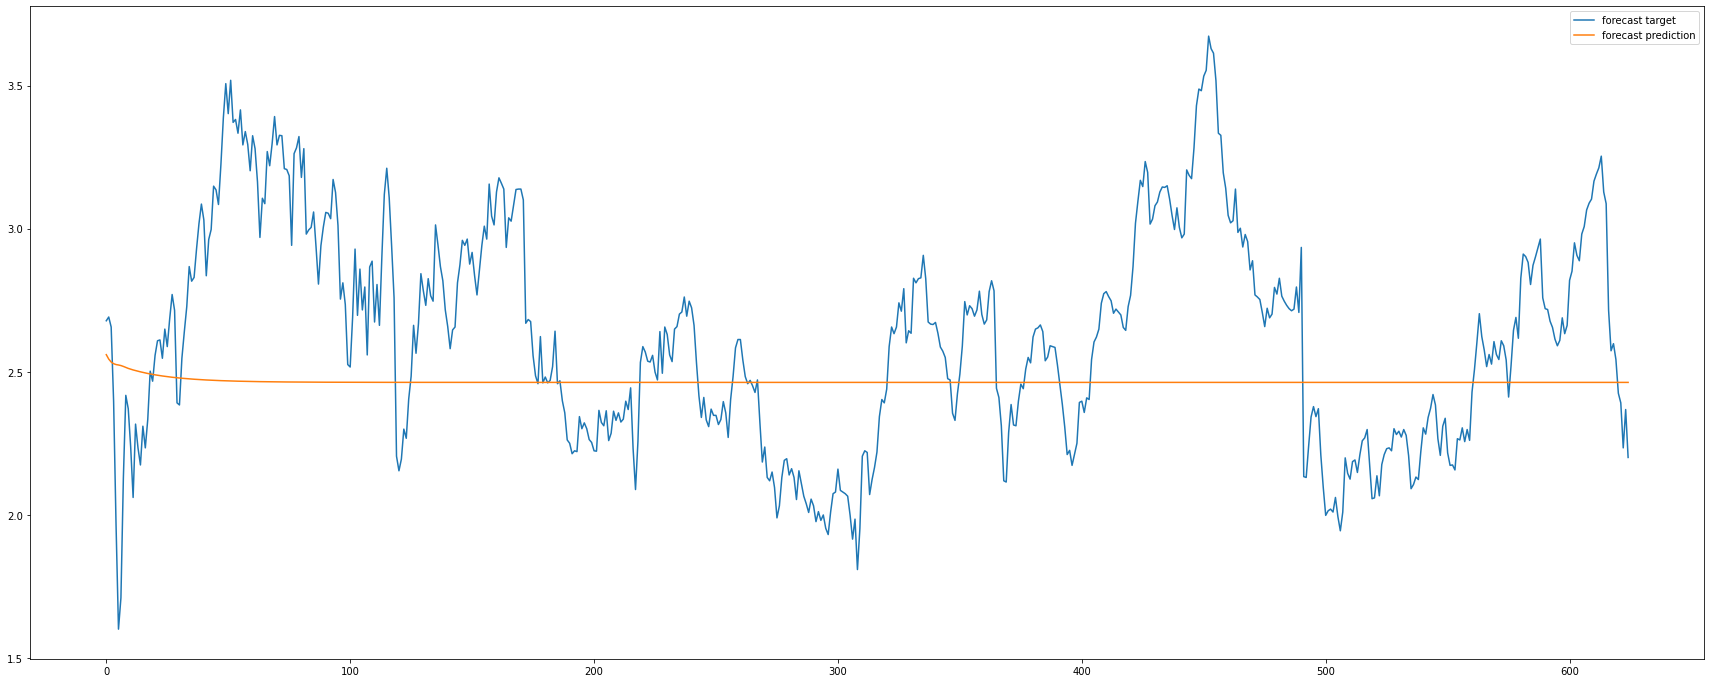

In [13]:
# Multi step forecast. The right way to forecast
validation_target = Y[-N//2:]
validation_predictions = []
last_x = X[-N//2]

for _ in range(len(validation_target)):
  p = model.predict(last_x.reshape(1, T, 1))[0,0]
  validation_predictions.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


plt.figure(figsize=(30,12))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [14]:
#All the model does it copy the previous value. The model is useless
#Now will try to predict the return instead of the stock value

In [15]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

In [16]:
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

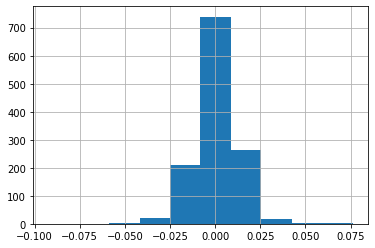

In [17]:
df['Return'].hist()

In [18]:
series = df['Return'].values[1:].reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [19]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [20]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 28ms/step - loss: 1.0044 - val_loss: 1.1432
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9941 - val_loss: 1.1355
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9906 - val_loss: 1.1498
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9849 - val_loss: 1.1426
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9864 - val_loss: 1.1466
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9860 - val_loss: 1.1475
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9846 - val_loss: 1.1503
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9839 - val_loss: 1.1411
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9835 - val_loss: 1.1423
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9837 - val_loss: 1.1483
Epoch 11/80
20/20 

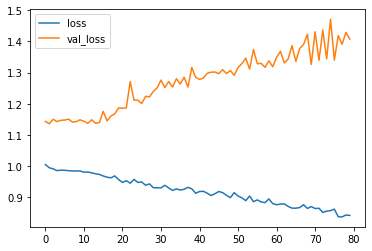

In [21]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


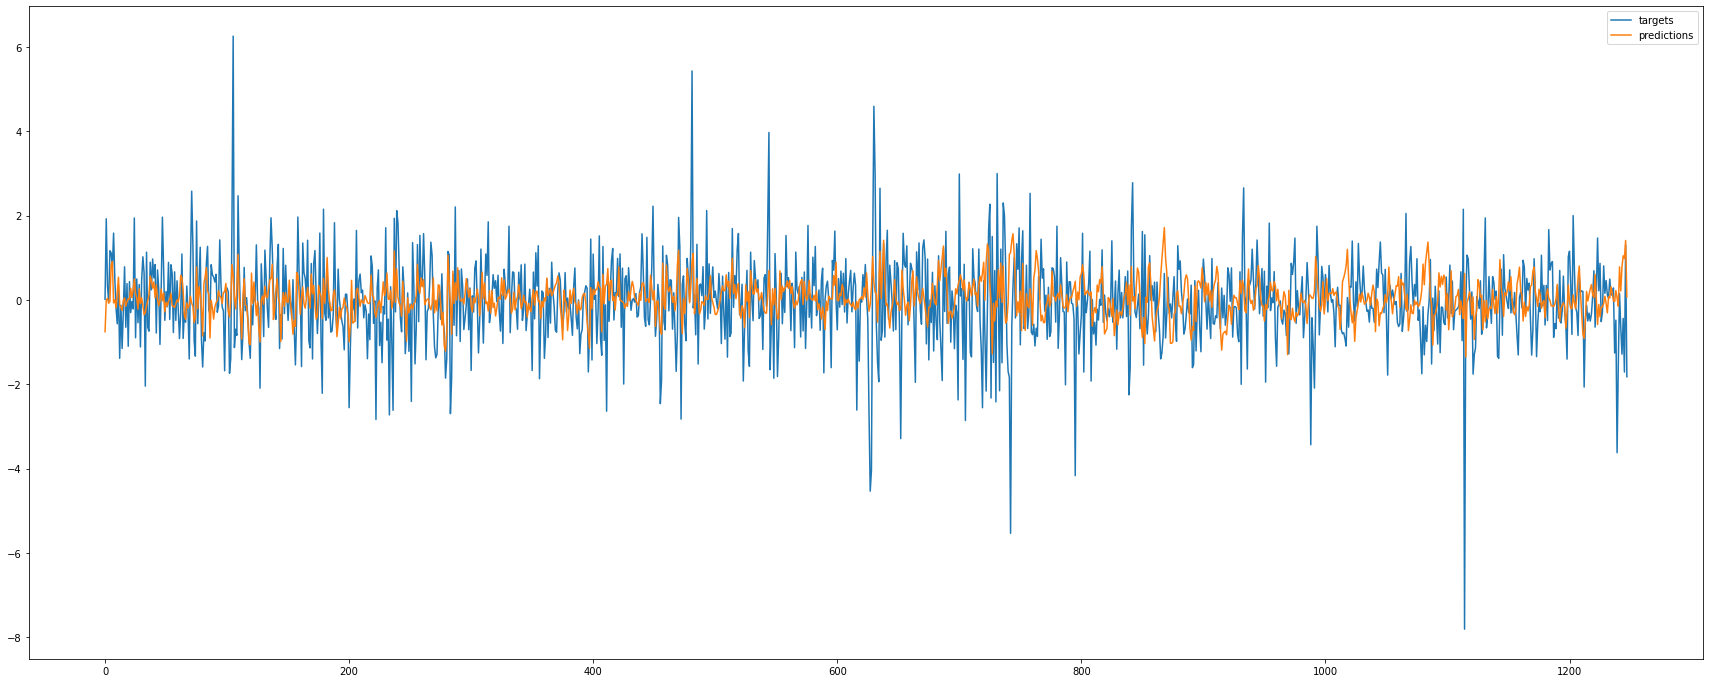

In [22]:
# One step forecast. Again the wrong thing to do
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]
plt.figure(figsize=(30,12))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

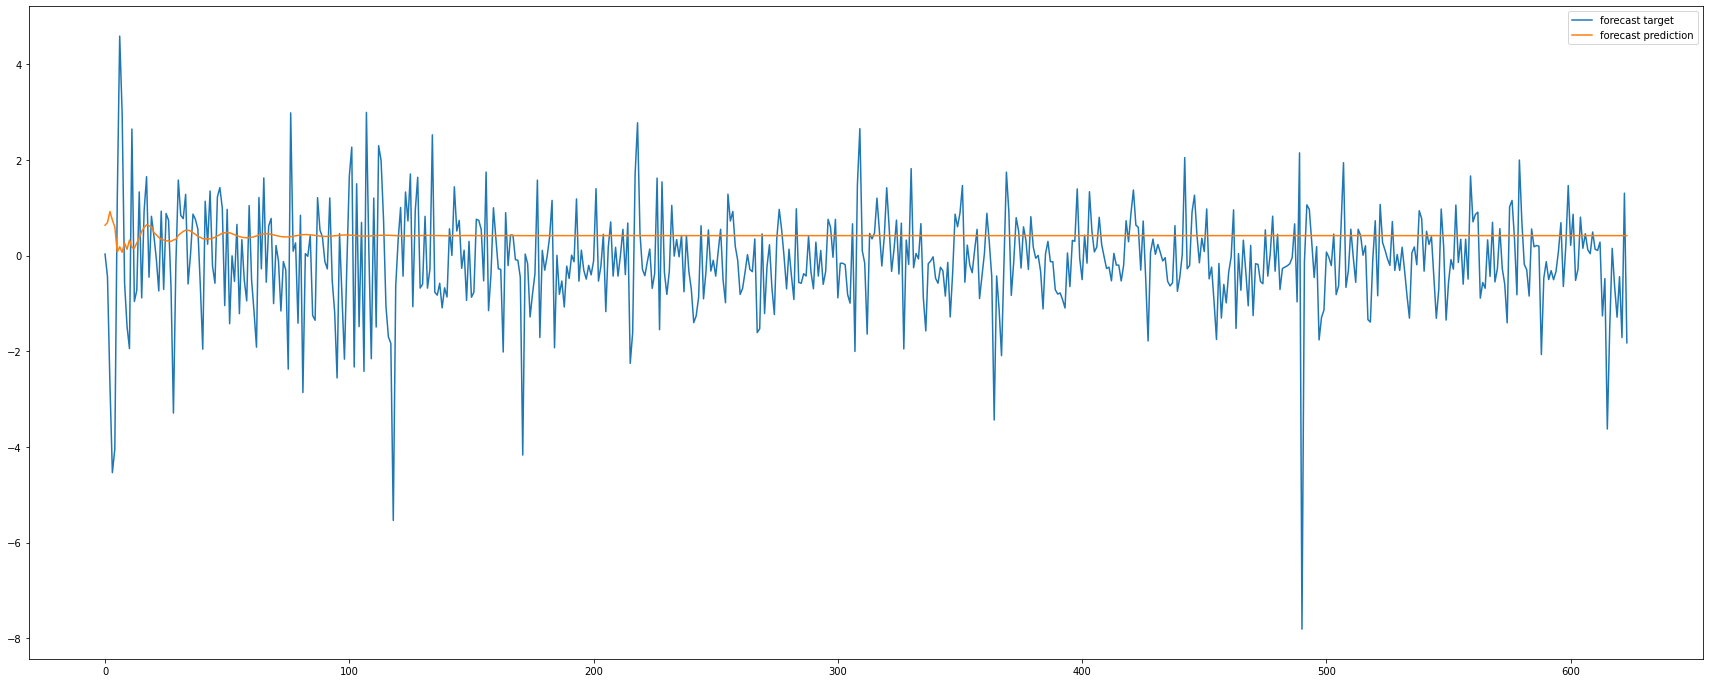

In [23]:
# Multi step forecast. The right way to forecast
validation_target = Y[-N//2:]
validation_predictions = []
last_x = X[-N//2]

for _ in range(len(validation_target)):
  p = model.predict(last_x.reshape(1, T, 1))[0,0]
  validation_predictions.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


plt.figure(figsize=(30,12))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [24]:
#Again we can see that all this model does is copy the previous value. Just like the previous model, it is useless

In [25]:
#Now let's use all the data and use it to predict simply if the price will rise or fall.

In [26]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [27]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [28]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [30]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)


X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)


for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

for u in range(N - Ntrain):
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [31]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [32]:
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 30ms/step - loss: 0.7027 - accuracy: 0.4875 - val_loss: 0.6984 - val_accuracy: 0.4659
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.5066 - val_loss: 0.6959 - val_accuracy: 0.4780
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4851 - val_loss: 0.6949 - val_accuracy: 0.4756
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5173 - val_loss: 0.6936 - val_accuracy: 0.5171
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5209 - val_loss: 0.7034 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5268 - val_loss: 0.6933 - val_accuracy: 0.4976
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.5232 - val_loss: 0.6930 - val_accuracy: 0.4976
Epoch 8/300


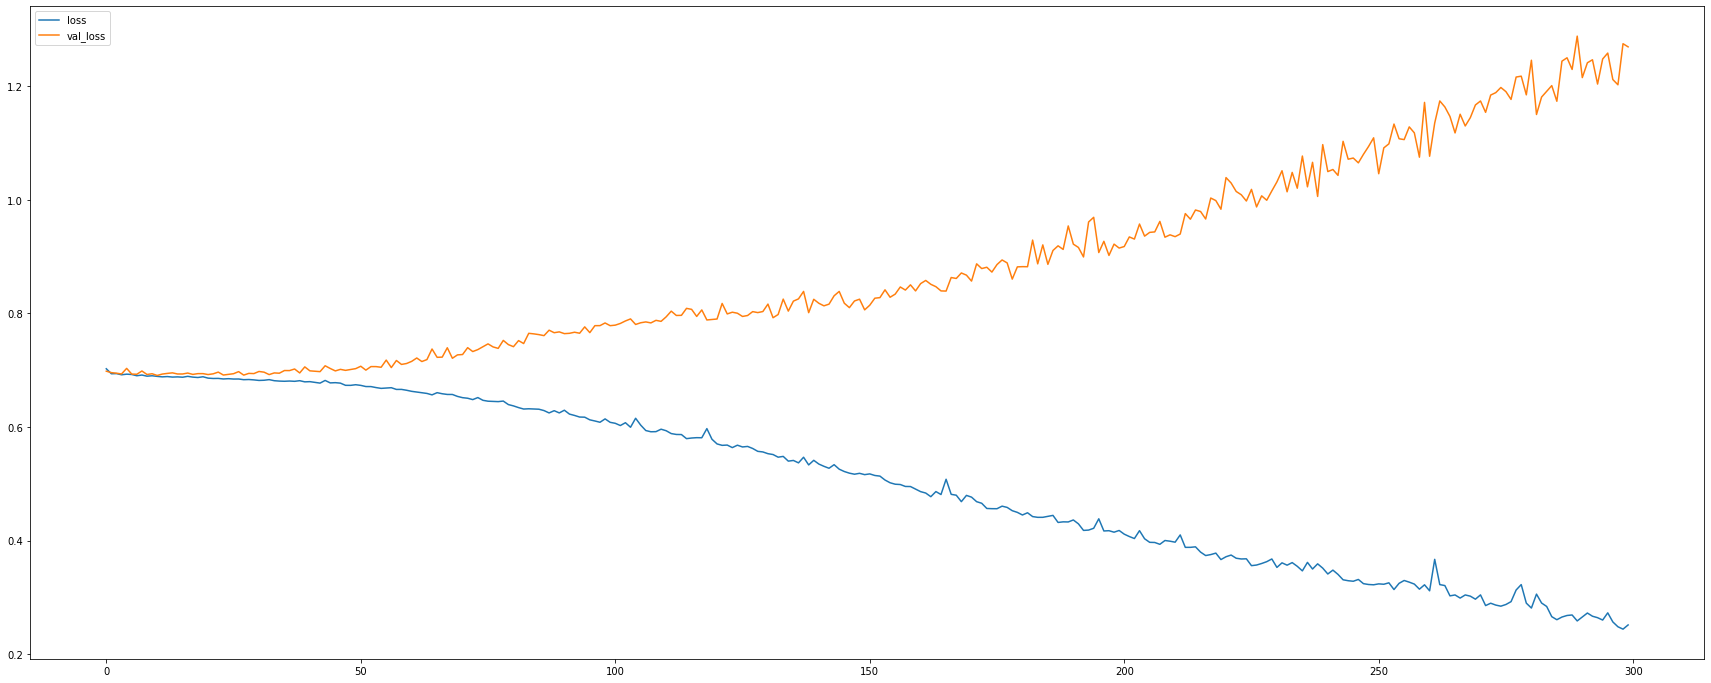

In [33]:
plt.figure(figsize=(30,12))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

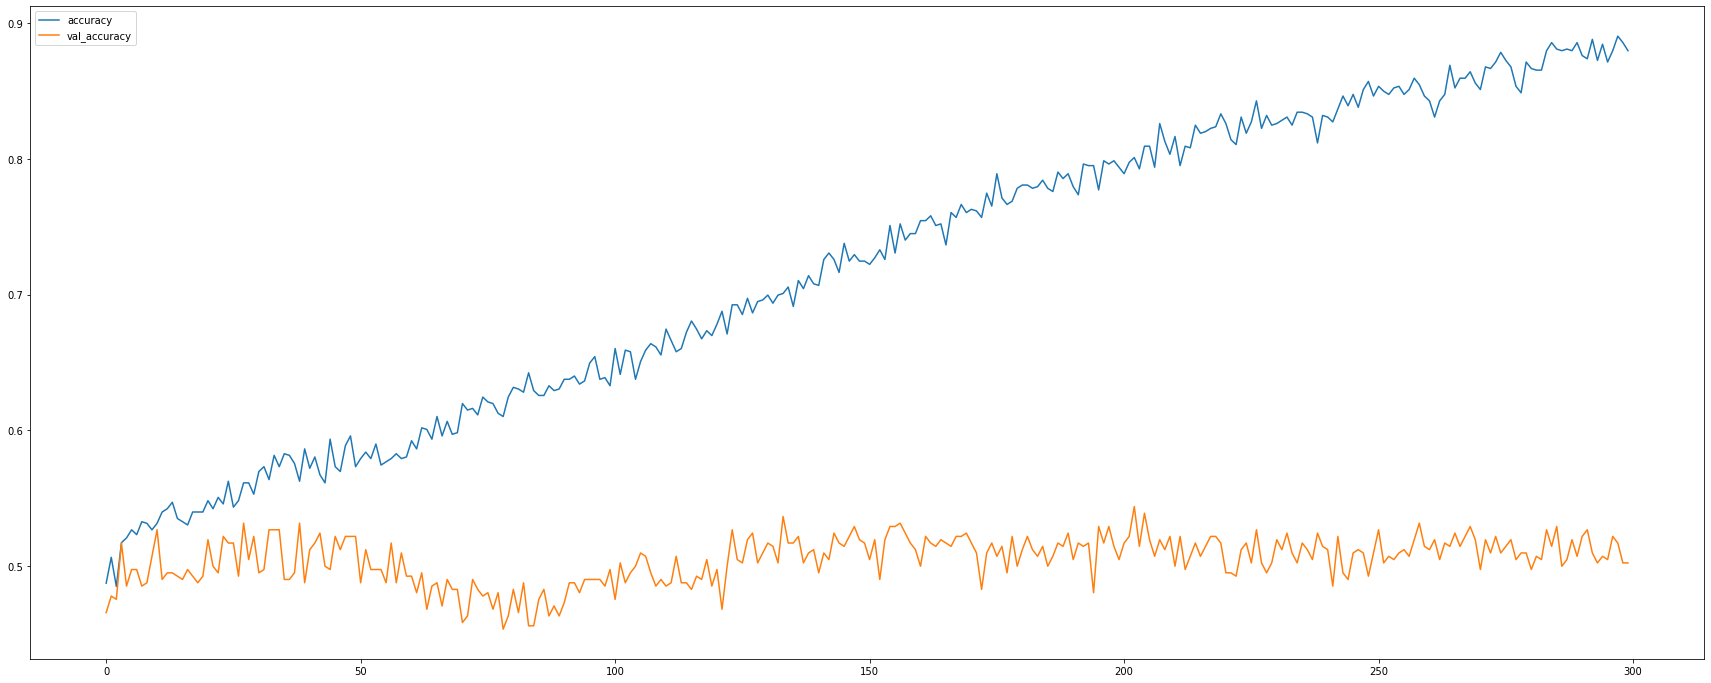

In [34]:
plt.figure(figsize=(30,12))
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

### So we can see that we can get an accuracy of only about 50%. That is the worst possible accuracy for a classification problem.

## This shows that predicting stock prices based upon historic data does not make any sense. In the real world, stock prices depend upon real world events Claiming to predict stock prices using historic data and a LSTM model is completely misleading 